In [26]:
import ants
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [19]:
#Apply pipeline to all images

files_brain = glob.glob("Datasets/QIN-DSC-BRAIN/brain_mask/*.nii")
files_tumor = glob.glob("Datasets/QIN-DSC-BRAIN/tumor_mask/*.nii")

atlas = ants.image_read("Atlases/sri24_spm8/templates/T1_brain.nii")
atlas = atlas.reorient_image2("RAI")

for i in range(len(files_brain)):
    im = ants.image_read(files_brain[i])
    im = im.reorient_image2("RAI")
    mytx = ants.registration(fixed=atlas, moving=im, type_of_transform='Rigid')
    tumor = ants.image_read(files_tumor[i])
    tumor = tumor.reorient_image2("RAI")
    tumor_warped = ants.apply_transforms(fixed=mytx['warpedmovout'], moving=tumor, transformlist=mytx['fwdtransforms'])
    ants.image_write(tumor_warped, "Datasets/QIN-DSC-BRAIN/tumor_mask_warped/" + "tumor_mask_warped" + str(i) + ".nii")
    ants.image_write(mytx['warpedmovout'], "Datasets/QIN-DSC-BRAIN/brain_mask_warped/" + "brain_mask_warped" + str(i) + ".nii")

In [24]:
# Get tumor mask warped files

files_tumor_warped = glob.glob("Datasets/QIN-DSC-BRAIN/tumor_mask_warped/*.nii")

result_array = np.zeros((240,240,155))
for file in files_tumor_warped:
    im = nib.load(file)
    im = im.get_fdata()

    im[im > 0] = 1

    result_array = result_array + im

result_array = result_array / len(files_tumor_warped)

img_final = nib.Nifti1Image(result_array, np.eye(4))
nib.save(img_final, 'Datasets/QIN-DSC-BRAIN/probdist/probdist_QIN.nii')

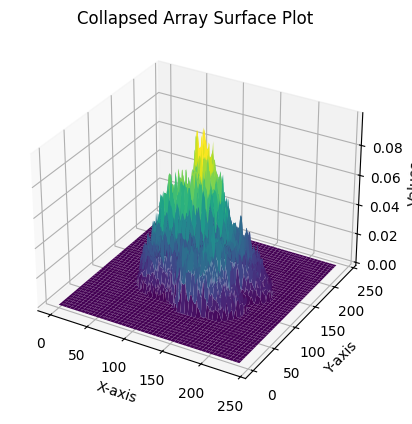

In [28]:
prob_dist = result_array/len(files_tumor_warped)

collapsed_array = np.sum(prob_dist, axis=2)

# Create X, Y grids for the surface plot
x = np.arange(0, collapsed_array.shape[1])
y = np.arange(0, collapsed_array.shape[0])
X, Y = np.meshgrid(x, y)

# Plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, collapsed_array, cmap='viridis')

ax.set_title("Collapsed Array Surface Plot")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Values")

plt.savefig("surface_plot.png")
plt.savefig("Datasets/QIN-DSC-BRAIN/probdist/QIN-DSC-BRAIN_surface_plot.png")